In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from PIL import Image

In [3]:
lr_dim = 64
hr_dim = 256
epochs = 100
scale_factor = hr_dim // lr_dim
batch_size = 1

In [4]:
def load_image_lr(path):
    im = Image.open(path)
    im_dims =  im.size

    # load the image in lr_dim, lr_dim
    im = im.resize((lr_dim, lr_dim))
    im = np.array(im).astype(np.float32)
    im = im[:, :, :3]
    return np.expand_dims((im / 255), axis=0)

In [5]:
def downscale(x, factor=2):
    return tf.image.resize(x, (x.shape[1] // factor, x.shape[2] // factor), method="area")

In [6]:
model = keras.models.load_model(f"./models/SRGAN/gen/generator-320")

In [7]:
file_path = "./images/SRTEST_section.png"
# file_path = "./images/burger.jpg"
# file_path = "./images/number_plate_lr.png"
# file_path = "./images/number_plate.png"
lr_image = load_image_lr(file_path)

In [8]:
# resize the plt plot to 16, 16
plt.rcParams['figure.figsize'] = (16, 16)

In [9]:
import cv2

def traditional_upscale_numpy(img, scale_factor):
    _output = img
    _output = cv2.resize(_output, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    return _output

def traditional_upscale(img_path, method=cv2.INTER_NEAREST):
    img = cv2.imread(img_path)
    # BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (lr_dim, lr_dim))
    img = cv2.resize(img, (hr_dim, hr_dim), interpolation=method)
    # return as numpy
    
    return img/255

In [10]:
def upscale(img):
    _output = model(img)[0]

    # clip values between 0 and 1
    _output = np.clip(_output, 0, 1)

    return _output

In [11]:
def upscale_file(filepath):
    _img = load_image_lr(filepath)
    _output = upscale(_img)
    return _img, _output

In [12]:
# enlarge the image to the dim_ratio
def unpack(img, dim_ratio):
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((int(img.size[0] * dim_ratio), int(img.size[1])))
    return img

# enlarges the image in the given axis to the dim_ratio
def unpack_in_axis(img, dim_ratio, axis):
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)

    if axis == 1:
        img = img.resize((int(img.size[0] * dim_ratio), int(img.size[1])))

    if axis == 0:
        img = img.resize((int(img.size[0]), int(img.size[1] * dim_ratio)))
        
    return np.array(img, dtype=np.float32)/255


# squeezes the image such that both dimensions are divisible by 64
def pack(img):
    pack_axis = np.argmin(img.shape[:-1])
    lower_dim = img.shape[pack_axis]
    dim_ratio = img.shape[0] / img.shape[1]
    # resize image to the lower dimension
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((int(lower_dim), int(lower_dim)))  
    img = np.array(img)
    img = img.astype(np.float32)

    return img/255, dim_ratio, pack_axis
    

In [21]:
# file_path = "./images/elon.png"
file_path = "./images/real_small.jpeg"
# file_path = "./images/number_plate_lr.png"
# file_path = "./images/number_plate.png"

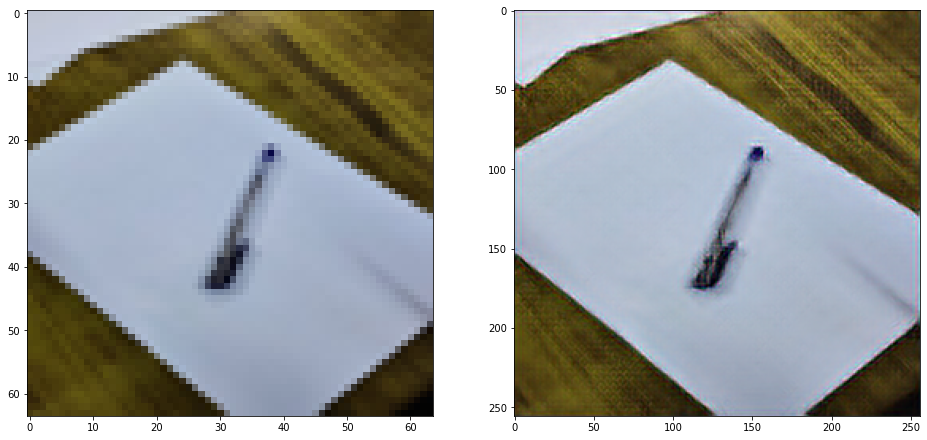

In [22]:
original, ai_upscaled = upscale_file(file_path)

plt.subplot(1, 2, 1)
plt.imshow(pack(original[0])[0])
plt.subplot(1, 2, 2)
plt.imshow(ai_upscaled)
plt.show()

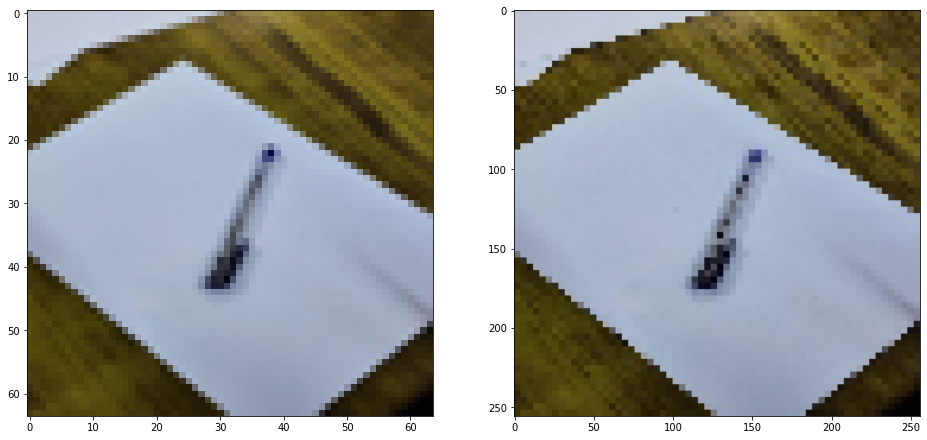

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(pack(original[0])[0])
plt.subplot(1, 2, 2)
plt.imshow(traditional_upscale(file_path, method=cv2.INTER_NEAREST
))
plt.show()